## Librerías

In [ ]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import random
from PIL import Image
from copy import copy, deepcopy
from IPython.display import display

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from tqdm.notebook import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import torchvision.models as models
import torchvision.transforms as transforms

from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import RegNet_Y_128GF_Weights

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Load Dataset

In [ ]:
repo_url = 'https://github.com/brendenlake/omniglot.git'
subprocess.call(['git', 'clone', repo_url])

0

In [ ]:
!unzip -qq './omniglot/python/images_background.zip'
!unzip -qq './omniglot/python/strokes_background.zip'

## Orden de las imágenes

En la carpeta images_background, hay 30 alfabetos diferentes. Cada alfabeto contiene una cantidad variada de caracteres, entre 20-50 aprox. Cada uno de los caracteres cuenta es de la forma XXXX_YY.png, donde XXXX corresponde al identificador del caracter, el cual es único entre todos los caracteres de todos los alfabetos. YY corresponde al número de muestra de un caracter en específico, el cual va siempre desde 01 hasta 20 (20 muestras por caracter).

Ahora bien, el problema está en que los XXXX no vienen ordenados secuencialmente en cada uno de los alfabetos. Por lo tanto, para hacer el preprocesamiento, hará un diccionario que mapeará cada uno de los id a un valor ordenado, para que la posterior clasificación sea más rápida.

In [ ]:
img_dir = 'images_background'
# stroke_dir = 'strokes_background'
nreps = 20 # number of renditions for each character
# nalpha = 5 # number of alphabets to show

alphabet_names = sorted([a for a in os.listdir(img_dir) if a[0] != '.']) # get folder names
length_alphabet_names = len(alphabet_names)
character_lengths = [len(os.listdir(os.path.join(img_dir, alph_name))) for alph_name in alphabet_names]

# alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets
# print(len(alphabet_names))

N = sum([len(os.listdir(os.path.join(img_dir, alph_name, char)))
            for alph_name in alphabet_names
            for char in os.listdir(os.path.join(img_dir, alph_name))
      ])


y = np.zeros((N), 'int') # ground truth
current_character_folder = 0 # carpeta de un caracter visitado

df_alphabet_names = []
df_character_names = []
df_character_idx = []
df_paths = []
df_y = []

for i in range(len(alphabet_names)):
  alphabet_name = alphabet_names[i]
  character_length = character_lengths[i]
  character_folders = sorted(os.listdir(os.path.join(img_dir, alphabet_name)))

  for j in range(character_length):
    character_folder = character_folders[j]
    characters = sorted(os.listdir(os.path.join(img_dir, alphabet_name, character_folder)))
    # print(character_folder)

    for k in range(nreps):
      y[(current_character_folder * nreps) + k] = current_character_folder

      # Se añade al Df
      df_alphabet_names.extend([alphabet_name])
      df_character_names.extend([character_folder])
      df_character_idx.extend([k])
      df_paths.extend([os.path.join(img_dir, alphabet_name, character_folder, characters[k])])
      df_y.extend([current_character_folder])

    current_character_folder += 1


df = pd.DataFrame({
    'Alphabet': df_alphabet_names,
    'Character': df_character_names,
    'Sample': df_character_idx,
    'Path': df_paths,
    'y': df_y
})

Al observar las muestras que tenemos, se obtiene lo siguiente

In [ ]:
df

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
...,...,...,...,...,...
19275,Tifinagh,character55,15,images_background/Tifinagh/character55/0964_16...,963
19276,Tifinagh,character55,16,images_background/Tifinagh/character55/0964_17...,963
19277,Tifinagh,character55,17,images_background/Tifinagh/character55/0964_18...,963
19278,Tifinagh,character55,18,images_background/Tifinagh/character55/0964_19...,963


## Ejemplo de una imagen

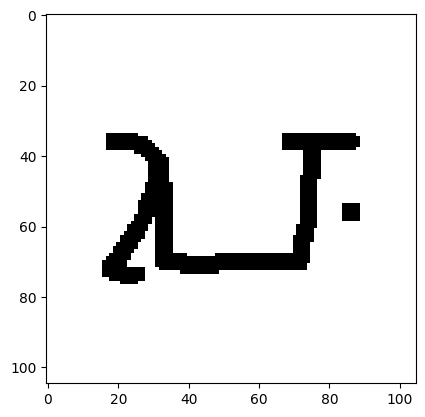

In [ ]:
path = df.iloc[0]['Path']
img = Image.open(path)
# print('Shape:', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7F9025B172E0>


## Separación Train - Val - Test:

El objetivo de la ResNet es justamente clasificar cada uno de los caracteres. En total, tenemos 964 caracteres distintos (labels enumerados del 0 al 963), provenientes de 30 alfabetos, y cada caracter posee 20 muestras. Por ende, tenemos 19280 imagenes distintas.

Dado que cada caracter posee 20 muestras, se utilizará una proporción 70% train, 20% validation y 10% test. Vale decir: 14 imágenes de train, 4 de validation, y 2 de test por cada caracter.

En total debería dar:
* 13.496 imágenes de Train
* 3.856 imágenes de Validation
* 1.928 imágenes de Test

In [ ]:
# Separacion de df basados en el numero de fila
df_train = df.groupby('y').head(14)
df_val = df.groupby('y').apply(lambda x: x.iloc[14:18])
df_test = df.groupby('y').apply(lambda x: x.iloc[18:20])

# Reseteamos los indices de los df
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [ ]:
print('Length df_train:', len(df_train))
print('Length df_val:', len(df_val))
print('Length df_test:', len(df_test))

Length df_train: 13496
Length df_val: 3856
Length df_test: 1928


Por ejemplo, si vemos como quedó el df_train:

In [ ]:
df_train[0:20]

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
5,Alphabet_of_the_Magi,character01,5,images_background/Alphabet_of_the_Magi/charact...,0
6,Alphabet_of_the_Magi,character01,6,images_background/Alphabet_of_the_Magi/charact...,0
7,Alphabet_of_the_Magi,character01,7,images_background/Alphabet_of_the_Magi/charact...,0
8,Alphabet_of_the_Magi,character01,8,images_background/Alphabet_of_the_Magi/charact...,0
9,Alphabet_of_the_Magi,character01,9,images_background/Alphabet_of_the_Magi/charact...,0


## Modelo ResNeXt

In [ ]:
num_classes = 964 # Cantidad de clases que hay

## Train

In [ ]:
class Character(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
        # img = plt.imread(path)
        img = Image.open(path)
        return img

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = Character(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_dataset = Character(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_dataset = Character(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
print('Train Dataset Length:', len(train_dataset))
print('Val Dataset Length:', len(val_dataset))
print('Test Dataset Length:', len(test_dataset))

Train Dataset Length: 13496
Val Dataset Length: 3856
Test Dataset Length: 1928


In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([64, 3, 105, 105]) torch.Size([64])


In [ ]:
len(train_loader)

211

In [ ]:
os.makedirs('models', exist_ok=True)
model_path = 'models/RegNet'


## Test

In [ ]:
# Función para correr inferencia usando un modelo y un
# DataLoader con nuestros datos del set de test.
def test_model(model, test_dl):
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in test_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        model.eval()                        # Dejamos el modelo en modo evaluación
        with torch.no_grad():               # No se calculará información de gradientes
                                            # en el código de más abajo.
            x = x.cuda()
            target = target.cuda()          # Enviamos nuestros datos a GPU
            output = model(x)               # Hacemos el forward de nuestros datos

            preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
            correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
            total_correctas += correctas
            total_muestras += target.shape[0]        # Sumamos el tamaño del batch

            accuracy = total_correctas/total_muestras # Acc = correctas/total

    return accuracy

In [ ]:
model = models.regnet_y_128gf(weights=RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1)
model.fc = nn.Linear(7392, num_classes, bias=True)
model.aux_logits=False
model.to(device)

for param in model.parameters(): param.requires_grad = False

# Descongelamos la última capa
for param in model.fc.parameters(): param.requires_grad = True

summary(model, input_size=(3, 105, 105))

criterion = nn.CrossEntropyLoss()
learning_rate = "1e-2"
l_r = 1e-2
opti = "SGD"
optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=l_r)
# optimizer = optim.Adagrad(model.parameters(), lr=0.009, lr_decay=0.0001)
# optimizer = optim.ASGD(model.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 53, 53]             864
       BatchNorm2d-2           [-1, 32, 53, 53]              64
              ReLU-3           [-1, 32, 53, 53]               0
            Conv2d-4          [-1, 528, 27, 27]          16,896
       BatchNorm2d-5          [-1, 528, 27, 27]           1,056
            Conv2d-6          [-1, 528, 53, 53]          16,896
       BatchNorm2d-7          [-1, 528, 53, 53]           1,056
              ReLU-8          [-1, 528, 53, 53]               0
            Conv2d-9          [-1, 528, 27, 27]       1,254,528
      BatchNorm2d-10          [-1, 528, 27, 27]           1,056
             ReLU-11          [-1, 528, 27, 27]               0
AdaptiveAvgPool2d-12            [-1, 528, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]           4,232
             ReLU-14              [-1, 

| Modelo | Optimizador | Learning Rate | Params | Epoch | Acc Train | Acc Val | Acc Test |
| -----  | ----- | ---- | ---- | ---- | ---- | ---- | ---- |
| RegNet | SGD | 1e-3 | momentum=0.9 | 10 | 0.885 | 0.169 | 0.168 |
| RegNet | SGD | 1e-2 | momentum=0.9 | 8 | 0.993 | 0.210 | 0.212 |
| RegNet | SGD | 1e-1 | momentum=0.9 | 10 | 0.995 | 0.157 | 0.156 |
| RegNet | Adam | 3e-3 | | 3 | 0.888 | 0.140 | 0.131 |


In [ ]:
# Para guardar los valores que queremos visualizar
ovrl_history = {
    'epochs': [],
    'train': {'loss': [], 'acc': []},
    'val': {'loss': [], 'acc': []},
    'test': {'loss': [], 'acc': []},
}

n_epochs = 10

for epoch in range(n_epochs):
    losses = []
    cum_loss = 0.0
    cum_acc = 0.0
    with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
      tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
      for batch, (data, targets) in enumerate(tepoch, start=1):
        optimizer.zero_grad()
        data = data.to(device)
        targets = targets.to(device)

        preds = model(data)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(preds, dim=1)
        cum_acc += torch.sum(preds == targets)

        # Cifras de desempeño
        cum_loss += loss.item()
        curr_loss = cum_loss / batch
        curr_acc = cum_acc / (batch * batch_size)
        tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc.item())
        losses.append(loss.item())

        torch.cuda.empty_cache()

    epoch_loss = float(cum_loss / batch)
    epoch_acc = float(cum_acc / (batch * batch_size))

    # Guardamos la epoca
    ovrl_history['epochs'].append(epoch)

    # Guardamos el loss y accuracy para la epoca
    ovrl_history['train']['loss'].append(epoch_loss)
    ovrl_history['train']['acc'].append(epoch_acc)

    # Guardamos el loss y accuracy en el set de validacion
    val_acc = test_model(model, val_loader)
    ovrl_history['val']['loss'].append(epoch_loss)
    ovrl_history['val']['acc'].append(float(val_acc))
    print(f'Validation Accuracy: {val_acc}')

    # Guardamos el loss y accuracy en el set de testing
    test_acc = test_model(model, test_loader)
    ovrl_history['test']['acc'].append(float(test_acc))
    print(f'Testing Accuracy: {test_acc}')

    # Guardamos el progreso actual en caso de que se corte la sesión.
    # Debe existir el directorio
    # Se guarda cada una de las epocas distintas para despues graficarla
    torch.save(model, model_path + '_' + str(epoch).zfill(3) + f'_{learning_rate}_{opti}' + '.pt')

    print(f'Epoch {epoch + 1} finished\n')

Epoch 0/20: 100%|██████████| 211/211 [04:50<00:00,  1.38s/batch, Acc=0.0502, Loss=6.23]


Validation Accuracy: 0.11747925728559494
Testing Accuracy: 0.1270746886730194
Epoch 1 finished



Epoch 1/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.437, Loss=3.42]


Validation Accuracy: 0.1667531281709671
Testing Accuracy: 0.1685684770345688
Epoch 2 finished



Epoch 2/20: 100%|██████████| 211/211 [04:56<00:00,  1.41s/batch, Acc=0.88, Loss=1.44]


Validation Accuracy: 0.19087137281894684
Testing Accuracy: 0.192427396774292
Epoch 3 finished



Epoch 3/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.97, Loss=0.811]


Validation Accuracy: 0.20072615146636963
Testing Accuracy: 0.20591287314891815
Epoch 4 finished



Epoch 4/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.988, Loss=0.501]


Validation Accuracy: 0.1994294673204422
Testing Accuracy: 0.2033195197582245
Epoch 5 finished



Epoch 5/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.989, Loss=0.388]


Validation Accuracy: 0.20565353333950043
Testing Accuracy: 0.21161827445030212
Epoch 6 finished



Epoch 6/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.992, Loss=0.284]


Validation Accuracy: 0.21109959483146667
Testing Accuracy: 0.21058093011379242
Epoch 7 finished



Epoch 7/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.993, Loss=0.224]


Validation Accuracy: 0.21006225049495697
Testing Accuracy: 0.21161827445030212
Epoch 8 finished



Epoch 8/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.993, Loss=0.208]


Validation Accuracy: 0.21213693916797638
Testing Accuracy: 0.2064315527677536
Epoch 9 finished



Epoch 9/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.993, Loss=0.191]


Validation Accuracy: 0.21395228803157806
Testing Accuracy: 0.20228217542171478
Epoch 10 finished



Epoch 10/20: 100%|██████████| 211/211 [04:56<00:00,  1.41s/batch, Acc=0.993, Loss=0.163]


Validation Accuracy: 0.2152489721775055
Testing Accuracy: 0.208506241440773
Epoch 11 finished



Epoch 11/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.994, Loss=0.14]


Validation Accuracy: 0.2103215903043747
Testing Accuracy: 0.2053942084312439
Epoch 12 finished



Epoch 12/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.996, Loss=0.119]


Validation Accuracy: 0.21161827445030212
Testing Accuracy: 0.2074688971042633
Epoch 13 finished



Epoch 13/20: 100%|██████████| 211/211 [04:56<00:00,  1.41s/batch, Acc=0.996, Loss=0.117]


Validation Accuracy: 0.21109959483146667
Testing Accuracy: 0.20798756182193756
Epoch 14 finished



Epoch 14/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.996, Loss=0.0982]


Validation Accuracy: 0.209284245967865
Testing Accuracy: 0.21006225049495697
Epoch 15 finished



Epoch 15/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.995, Loss=0.11]


Validation Accuracy: 0.2064315527677536
Testing Accuracy: 0.2064315527677536
Epoch 16 finished



Epoch 16/20: 100%|██████████| 211/211 [04:57<00:00,  1.41s/batch, Acc=0.996, Loss=0.0972]


Validation Accuracy: 0.20902490615844727
Testing Accuracy: 0.20695021748542786
Epoch 17 finished



Epoch 17/20:  61%|██████    | 128/211 [03:01<01:57,  1.42s/batch, Acc=0.997, Loss=0.0943]


KeyboardInterrupt: ignored